In [1]:
import sys
sys.path.insert(0, '../src/')

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import torch
import scipy.sparse as sp
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import roc_auc_score, average_precision_score
import time
import pickle
import pandas as pd
%matplotlib inline

from net.utils import *
from net import utils_netgan as utils
import net.net as net

[[0.1 1.1]
 [0.2 1.2]
 [0.3 1.3]]


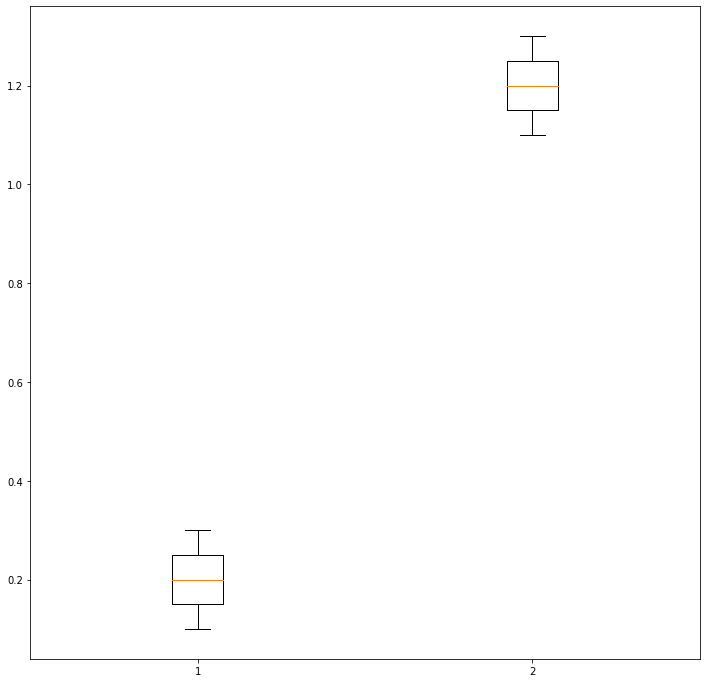

In [5]:
A = np.array([[0.1, 0.2, 0.3], [1.1, 1.2, 1.3]]).T
print(A)

f, axs = plt.subplots(figsize=(12,12))
axs.boxplot(A)
plt.show()

# Run pipeline several times and plot average during training

In [2]:
def main(train_graph, val_ones, val_zeros, H, steps, optimizer_args, log_every, print_every):
    # Apply pipeline to generate a graph with our method
    W = train_graph.toarray()
    W /= W.sum()

    netmodel = net.NetWithoutSampling(W=W, 
                                      H=H, 
                                      loggers=[net.GraphStatisticsLoggerWithoutSampling(train_graph, 
                                                                                        val_ones,
                                                                                        val_zeros,
                                                                                        log_every=log_every),
                                               net.OverlapLoggerWithoutSampling(train_graph, 
                                                                                print_every=print_every)])

    netmodel.train(steps=steps,
                   optimizer_fn=torch.optim.Adam,
                   optimizer_args=optimizer_args)

    transition_matrix = netmodel()

    scores_matrix = scores_matrix_from_transition_matrix(transition_matrix=transition_matrix,
                                                         symmetric=True)
    scores_matrix = sp.csr_matrix(scores_matrix)

    sampled_graph = utils.graph_from_scores(scores_matrix, train_graph.sum())
    statistics_logger = netmodel.loggers[0]
    return sampled_graph, statistics_logger

#### Get graph

In [3]:
_A_obs, _X_obs, _z_obs = utils.load_npz('../data/cora_ml.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

val_share = 0.1
test_share = 0.05
seed = 481516234

train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=True)

train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

statistics_train = utils.compute_graph_statistics(train_graph.toarray())

Selecting 1 largest connected components


#### Train K times 

In [4]:
K = 30
statistics_loggers = []

for k in range(K):
    print(f'Step {k}')
    sampled_graph, statistics_logger = main(train_graph=train_graph, val_ones=val_ones,
                                            val_zeros=val_zeros,
                                            H=12, steps=250,
                                            optimizer_args={'lr' : 0.1, 'weight_decay' : 1e-5},
                                            log_every=5,
                                            print_every=50)
    statistics_loggers.append(statistics_logger)
statistics_loggers = [logger() for logger in statistics_loggers]    

Step 0
Step: 49, Loss: 2.43744, Edge-Overlap: 0.686
Step: 99, Loss: 2.29205, Edge-Overlap: 0.737
Step: 149, Loss: 2.25088, Edge-Overlap: 0.755
Step: 199, Loss: 2.23254, Edge-Overlap: 0.769
Step: 249, Loss: 2.22132, Edge-Overlap: 0.770
Step 1
Step: 49, Loss: 2.42866, Edge-Overlap: 0.693
Step: 99, Loss: 2.28831, Edge-Overlap: 0.732
Step: 149, Loss: 2.24280, Edge-Overlap: 0.752
Step: 199, Loss: 2.22385, Edge-Overlap: 0.762
Step: 249, Loss: 2.21421, Edge-Overlap: 0.767
Step 2
Step: 49, Loss: 2.43166, Edge-Overlap: 0.695
Step: 99, Loss: 2.29385, Edge-Overlap: 0.737
Step: 149, Loss: 2.25036, Edge-Overlap: 0.761
Step: 199, Loss: 2.23318, Edge-Overlap: 0.761
Step: 249, Loss: 2.22350, Edge-Overlap: 0.771
Step 3
Step: 49, Loss: 2.44088, Edge-Overlap: 0.689
Step: 99, Loss: 2.29178, Edge-Overlap: 0.737
Step: 149, Loss: 2.24974, Edge-Overlap: 0.752
Step: 199, Loss: 2.23031, Edge-Overlap: 0.763
Step: 249, Loss: 2.22025, Edge-Overlap: 0.770
Step 4
Step: 49, Loss: 2.44270, Edge-Overlap: 0.686
Step: 99

#### Saving and loading

In [17]:
pickle.dump(statistics_loggers, open("../data/statistics_loggers.p", "wb"))

NameError: name 'statistics_loggers' is not defined

In [19]:
statistics_loggers = pickle.load(open("../data/statistics_loggers.p", "rb"))

#### Make boxplot

In [21]:
def print_average_statistics(statistics_loggers, statistics_train, keys):
    n_cols, n_rows = get_plot_grid_size(len(keys))
    plt.rcParams.update({'font.size': 18})
    f, axs = plt.subplots(n_rows, n_cols, sharex=True, figsize=(22, 12))
    axs = np.array(axs).reshape(n_rows, n_cols)
    plt.tight_layout(pad=3)
    
    statistics_train['overlap'] = 1
    steps = statistics_loggers[0]['step']
    # Collect statistics in dict of lists of lists of statistics
    dict_of_lists_of_lists_of_statistics = {}
    for statistics in statistics_loggers:
        dict_of_lists_of_lists_of_statistics = update_dict_of_lists(dict_of_lists_of_lists_of_statistics,
                                                                    statistics)
    # Boxplot    
    for row in range(n_rows):
        for col in range(n_cols):
            i = row * n_cols + col
            if i < len(keys):
                key = keys[row * n_cols + col]
                axs[row, col].boxplot(np.array(dict_of_lists_of_lists_of_statistics[key]), positions=steps,
                                      widths=2,
                                      showfliers=False)
                axs[row, col].hlines(y=statistics_train[key],
                                     xmin=steps[0],
                                     xmax=steps[-1],
                                     colors='green',
                                     linestyles='dashed')        
                axs[row, col].yaxis.set_major_formatter(FuncFormatter(y_fmt))
                axs[row, col].set_xlabel('Training iteration', labelpad=5)               
                axs[row, col].set_ylabel(translate_key_for_plot(key), labelpad=2)
            else:
                axs[row, col].axis('off')
    #         plt.savefig('../fig/our_statistics_during_training.pdf', format='pdf')                    
    plt.show()  
    return dict_of_lists_of_lists_of_statistics

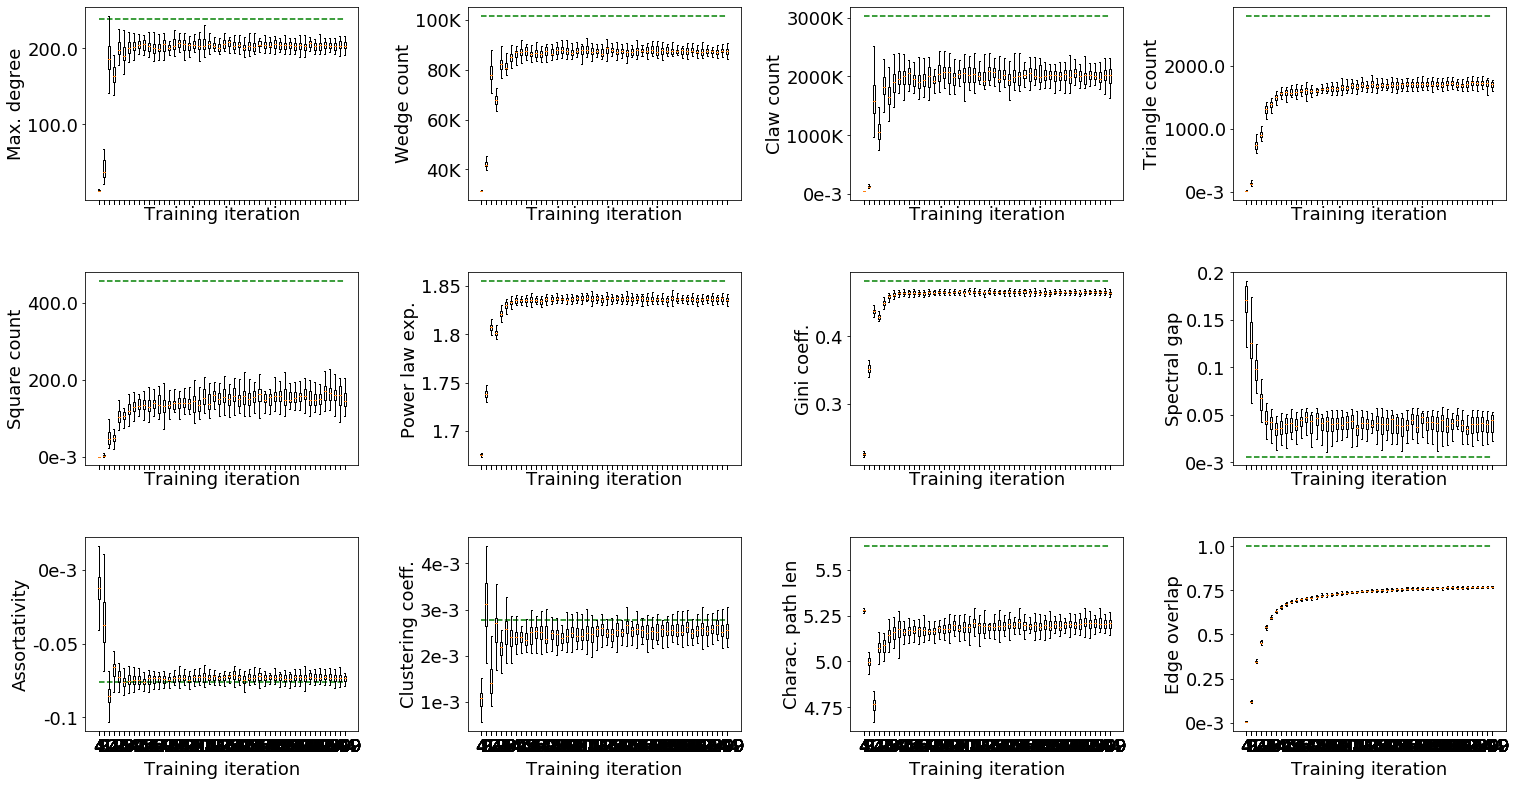

In [22]:
relevant_keys = ['d_max', 'wedge_count', 'claw_count', 'triangle_count', 'square_count',
                 'power_law_exp', 'gini', 'spectral_gap', 'assortativity', 'clustering_coefficient',
                 'cpl', 'overlap']

x = print_average_statistics(statistics_loggers=statistics_loggers,
                             statistics_train=statistics_train,
                             keys=relevant_keys)

# Same procedure with EO stopping criterion
Either take loggers from boxplots and search for corresponding entries with stopping criterion, or do pipeline again, but with EO stopper instead of loggers (=faster)

In [5]:
def main_with_EO(train_graph, H, EO_criterion, max_steps, optimizer_args, test_every, print_every):
    # Apply pipeline to generate a graph with our method
    E = train_graph.sum()
    W = train_graph.toarray()
    W /= W.sum()

    
    
    netmodel = net.NetWithoutSampling(W=W, H=H, 
                                      stoppers=[net.OverlapStopperWithoutSampling(train_graph=train_graph,
                                                                                  test_every=test_every)])

    netmodel.train(steps=max_steps,
                   optimizer_fn=torch.optim.Adam,
                   optimizer_args=optimizer_args,
                   EO_criterion=EO_criterion)

    transition_matrix = netmodel()

    scores_matrix = scores_matrix_from_transition_matrix(transition_matrix=transition_matrix,
                                                         symmetric=True)
    scores_matrix = sp.csr_matrix(scores_matrix)

    sampled_graph = utils.graph_from_scores(scores_matrix, train_graph.sum())
    EO_dict = utils.compute_graph_statistics(sampled_graph)
    EO_dict['overlap'] = utils.edge_overlap(train_graph.toarray(), sampled_graph)/E
    return sampled_graph, EO_dict

In [6]:
def get_overlap(graphs):
    """ Computes average edge overlap between to graphs and the edge overlap between all graphs, relative to
        the total amount of edges."""
    m = len(graphs)
    E = graphs[0].sum()
    average_overlap = 0
    total_overlap = np.ones_like(graphs[0])
    for i in range(m):
        total_overlap *= graphs[i]
        for j in range(i+1, m):
            average_overlap += utils.edge_overlap(graphs[i], graphs[j]) / E
    average_overlap /= m * (m - 1) / 2 
    total_overlap = total_overlap.sum() / E
    return average_overlap, total_overlap

In [8]:
K = 20
EO_dicts = []
configuration_dicts = []
output_graphs = []


for k in range(K):
    print(f'Step {k}')
    sampled_graph, EO_dict = main_with_EO(train_graph=train_graph,
                                          H=12, EO_criterion=0.52, max_steps=50,
                                          optimizer_args={'lr' : 0.1, 'weight_decay' : 1e-5},
                                          test_every=5,
                                          print_every=50)
    EO_dicts.append(EO_dict)
    output_graphs.append(sampled_graph)
    configuration_graph = configuration_model(A=train_graph.toarray(), B=sampled_graph)
    configuration_dicts.append(utils.compute_graph_statistics(configuration_graph)) 
overlaps = get_overlap(output_graphs)

Step 0
Step: 4, Loss: 7.24080, Edge-Overlap: 0.007
Step: 9, Loss: 5.24671, Edge-Overlap: 0.117
Step: 14, Loss: 4.00051, Edge-Overlap: 0.351
Step: 19, Loss: 3.34541, Edge-Overlap: 0.460
Step: 24, Loss: 2.98894, Edge-Overlap: 0.537
Step 1
Step: 4, Loss: 7.21692, Edge-Overlap: 0.007
Step: 9, Loss: 5.20453, Edge-Overlap: 0.116
Step: 14, Loss: 3.96771, Edge-Overlap: 0.349
Step: 19, Loss: 3.32420, Edge-Overlap: 0.454
Step: 24, Loss: 2.97342, Edge-Overlap: 0.547
Step 2
Step: 4, Loss: 7.23359, Edge-Overlap: 0.005
Step: 9, Loss: 5.23671, Edge-Overlap: 0.121
Step: 14, Loss: 3.99130, Edge-Overlap: 0.358
Step: 19, Loss: 3.34819, Edge-Overlap: 0.457
Step: 24, Loss: 2.99550, Edge-Overlap: 0.538
Step 3
Step: 4, Loss: 7.23795, Edge-Overlap: 0.005
Step: 9, Loss: 5.27348, Edge-Overlap: 0.118
Step: 14, Loss: 4.04098, Edge-Overlap: 0.337
Step: 19, Loss: 3.38191, Edge-Overlap: 0.446
Step: 24, Loss: 3.01556, Edge-Overlap: 0.544
Step 4
Step: 4, Loss: 7.23849, Edge-Overlap: 0.005
Step: 9, Loss: 5.26954, Edge-

#### Saving and loading

In [12]:
pickle.dump([EO_dicts, configuration_dicts, overlaps], open("../data/EO_graphs.p", "wb"))

In [4]:
EO_dicts, configuration_dicts, overlaps = pickle.load(open("../data/EO_graphs.p", "rb"))

In [5]:
def EO_dict_of_lists_from_loggers(statistics_loggers, EO_criterion=0.52):
    EO_dict_of_lists = {}
    for statistics in statistics_loggers:
        EO_statistics = {}
        EO_step = np.argmax(np.array(statistics['overlap'])>EO_criterion)
        for key in statistics.keys():
            EO_statistics[key] = statistics[key][EO_step]
        EO_dict_of_lists = update_dict_of_lists(EO_dict_of_lists, EO_statistics)
    return EO_dict_of_lists

def EO_dict_of_lists_from_dicts(EO_dicts):
    EO_dict_of_lists = {}
    for dict_of_statistics in EO_dicts:
        EO_dict_of_lists = update_dict_of_lists(EO_dict_of_lists, dict_of_statistics)
    return EO_dict_of_lists

def get_average_statistics(EO_dict_of_lists):
    dict_of_average_statistics = {}
    for key in EO_dict_of_lists.keys():
        values = np.array(EO_dict_of_lists[key])
        dict_of_average_statistics[key] = (values.mean(), values.std())
    return dict_of_average_statistics
    
def print_table_of_average_statistics(list_of_average_statistics, keys, method_names):
    formatted_list_of_average_statistics = []
    # Convert (mean, std) into 'mean \pm std'
    for average_statistics in list_of_average_statistics:
        if type(average_statistics[keys[0]])==tuple:
            formatted_statistics = {}
            for key in average_statistics.keys():
                mean, std = average_statistics[key]
                formatted_statistics[key] = f'{round(mean,3)} \u00B1 {round(std,3)}'
        else:
            formatted_statistics = average_statistics
        formatted_list_of_average_statistics.append(formatted_statistics)
    df = pd.DataFrame(formatted_list_of_average_statistics, 
                      index=method_names)
    return df[keys]

#### From training with loggers (indirect)

In [15]:
EO_dict_of_lists = EO_dict_of_lists_from_loggers(statistics_loggers=statistics_loggers)
dict_of_average_statistics = get_average_statistics(EO_dict_of_lists=EO_dict_of_lists)
print_table_of_average_statistics(list_of_average_statistics=[statistics_train,
                                                              dict_of_average_statistics],
                                  keys=relevant_keys,
                                  method_names=['CORA-ML', 'Our method'])

,d_max,wedge_count,claw_count,triangle_count,square_count,power_law_exp,gini,spectral_gap,assortativity,clustering_coefficient,cpl,overlap
CORA-ML,238,101747,3.03351e+06,2802,457,1.85506,0.481863,0.00611441,-0.0762641,0.00277104,5.63001,1
Our method,200.567 ± 11.514,82172.9 ± 2649.397,1852441.033 ± 234319.923,1311.0 ± 73.461,104.267 ± 19.946,1.822 ± 0.005,0.45 ± 0.004,0.045 ± 0.011,-0.073 ± 0.005,0.002 ± 0.0,5.088 ± 0.042,0.54 ± 0.007


#### From training with stopping criterion (direct)

In [ ]:
relevant_keys = ['d_max', 'wedge_count', 'claw_count', 'triangle_count', 'square_count',
                 'power_law_exp', 'gini', 'spectral_gap', 'assortativity', 'clustering_coefficient',
                 'cpl', 'overlap']

In [6]:
relevant_keys = ['d_max', 'assortativity', 'triangle_count', 'power_law_exp', 'clustering_coefficient',
                 'wedge_count', 'rel_edge_distr_entropy', 'LCC', 'claw_count', 'gini', 'overlap', 'cpl']

In [8]:
NetGAN_dict = {'d_max' : 233, 'assortativity' : -0.066, 'triangle_count' : 1588, 'power_law_exp' : 1.793,
               'clustering_coefficient' : '2.44e-3', 'wedge_count' : 86763, 'rel_edge_distr_entropy' : 0.954,
               'LCC' : 2807, 'claw_count' : '26e6', 'gini' : 0.42, 'overlap' : 0.52, 'cpl' : 5.2}

In [10]:
NetGAN_github_dict = {'d_max' : 214, 'assortativity' : '-', 'triangle_count' : 1552, 'power_law_exp' : 1.789,
               'clustering_coefficient' : '2.19e-3', 'wedge_count' : 82495, 'rel_edge_distr_entropy' : 0.954,
               'LCC' : 2802, 'claw_count' : 2118789, 'gini' : 0.42, 'overlap' : 0.52, 'cpl' : '-'}

In [ ]:
{'d_max': 214.0,
 'd_min': 1.0,
 'd': 4.8277580071174375,
 'LCC': 2802,
 'wedge_count': 82495.0,
 'claw_count': 2118789.0,
 'triangle_count': 1552,
 'square_count': 101,
 'power_law_exp': 1.789959868996088,
 'gini': 0.4214047784313202,
 'rel_edge_distr_entropy': 0.9542096912146562,
 'assortativity': -0.07439037839633739,
 'clustering_coefficient': 0.002197481674673599,
 'n_components': 5}

In [12]:
EO_dict_of_lists = EO_dict_of_lists_from_dicts(EO_dicts=EO_dicts)
conf_dict_of_lists = EO_dict_of_lists_from_dicts(EO_dicts=configuration_dicts)
dict_of_average_statistics = get_average_statistics(EO_dict_of_lists=EO_dict_of_lists)
conf_dict_of_average_statistics = get_average_statistics(EO_dict_of_lists=conf_dict_of_lists)
print_table_of_average_statistics(list_of_average_statistics=[statistics_train,
                                                              dict_of_average_statistics,
                                                              NetGAN_dict,
                                                              NetGAN_github_dict],
                                  keys=relevant_keys,
                                  method_names=['CORA-ML', 'Our method', 'NetGAN (paper)', 'NetGAN (github)'])

,d_max,assortativity,triangle_count,power_law_exp,clustering_coefficient,wedge_count,rel_edge_distr_entropy,LCC,claw_count,gini,overlap,cpl
CORA-ML,238,-0.0762641,2802,1.85506,0.00277104,101747,0.940663,2810,3.03351e+06,0.481863,NaN,5.63001
Our method,197.85 ± 13.222,-0.073 ± 0.005,1279.1 ± 67.183,1.82 ± 0.003,0.002 ± 0.0,81796.8 ± 2653.421,0.95 ± 0.001,2802.65 ± 3.021,1806563.4 ± 256683.897,0.448 ± 0.003,0.536 ± 0.007,5.08 ± 0.051
NetGAN (paper),233,-0.066,1588,1.793,2.44e-3,86763,0.954,2807,26e6,0.42,0.52,5.2
NetGAN (github),214,-,1552,1.789,2.19e-3,82495,0.954,2802,2118789,0.42,0.52,-


## Comparison with NetGAN (results from paper): 
We perform worse in local motifs (triangles, wedges, claws, d_max), but better in other statistics. Maybe NetGAN didn't use unbiased RWs here? Check our implementation

In [23]:
EO_dict_of_lists = EO_dict_of_lists_from_dicts(EO_dicts=EO_dicts)
conf_dict_of_lists = EO_dict_of_lists_from_dicts(EO_dicts=configuration_dicts)
dict_of_average_statistics = get_average_statistics(EO_dict_of_lists=EO_dict_of_lists)
conf_dict_of_average_statistics = get_average_statistics(EO_dict_of_lists=conf_dict_of_lists)
print_table_of_average_statistics(list_of_average_statistics=[statistics_train,
                                                              dict_of_average_statistics,
                                                              conf_dict_of_average_statistics],
                                  keys=relevant_keys,
                                  method_names=['CORA-ML', 'Our method', 'Configuration model'])

,d_max,wedge_count,claw_count,triangle_count,square_count,power_law_exp,gini,spectral_gap,assortativity,clustering_coefficient,cpl,overlap
CORA-ML,238,101747,3.03351e+06,2802,457,1.85506,0.481863,0.00611441,-0.0762641,0.00277104,5.63001,1
Our method,197.85 ± 13.222,81796.8 ± 2653.421,1806563.4 ± 256683.897,1279.1 ± 67.183,95.1 ± 21.758,1.82 ± 0.003,0.448 ± 0.003,0.048 ± 0.01,-0.073 ± 0.005,0.002 ± 0.0,5.08 ± 0.051,0.536 ± 0.007
Configuration model,231.8 ± 1.691,98516.8 ± 726.306,2808557.8 ± 57979.111,655.5 ± 42.844,19.8 ± 7.004,1.856 ± 0.0,0.48 ± 0.0,0.031 ± 0.013,-0.058 ± 0.004,0.001 ± 0.0,4.552 ± 0.02,NaN


# How large is the edge overlap between two output graphs at EO criterion?

In [17]:
print(f'Average relative edge overlap between output graphs is {overlaps[0]:.3f}.')
print(f'Relative edge overlap between all output graphs is {overlaps[1]:.3f}.')

Average relative edge overlap between output graphs is 0.344.
Relative edge overlap between all output graphs is 0.006.
